# Bayesian Inference Example
**Chris Mathys**

This is the example I use in my introductory lecture to Bayesian inference, developed for UCL's twice-yearly [SPM Courses](https://www.fil.ion.ucl.ac.uk/spm/course/).

We use [Julia](https://julialang.org/) and its probabilistic programming language [Turing.jl](https://turing.ml/).

In [1]:
# Setup
using Turing
using StatsBase
using DataFrames
using StatsPlots
using HypothesisTests

## The data

Two manufacturers, A and B, deliver the same kind of components. Your boss has bought a small sample from each and measured their lifetimes (in, say, days). Now he wants you to decide which manufucturer to buy from. He also tells you that the parts from B are more expensive, but if they live at least three days longer than those from A, buying from B ends up being cheaper. (Dataset created by simulation, adapted from an idea by Jaynes (1976)).

Lifetimes of parts from manufacturers A and B:


In [2]:
t = [59.6, 37.4, 47.6, 40.6, 48.6, 36.3, 31.5, 31.4, 45.7, 48.9, 48.7, 59.2, 51.9]


13-element Vector{Float64}:
 59.6
 37.4
 47.6
 40.6
 48.6
 36.3
 31.5
 31.4
 45.7
 48.9
 48.7
 59.2
 51.9

The first nine parts are from A (coded as 1), the last four from B (coded as 2).

In [3]:
m = [repeat([1] ,9); repeat([2], 4)]


13-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 2
 2
 2
 2

There are good reasons to analyze data that can only take positive values on a logarithmic scale. For example, if we simply applied a *t*-test to these two groups of observations, the implied model would allow for negative lifetimes, which doesn't make sense. Lifetimes are positive, so we log-transform them.

In [4]:
logt = log.(t)


13-element Vector{Float64}:
 4.087655574071304
 3.6216707044204863
 3.8628327612373745
 3.703768066607687
 3.883623530906448
 3.591817741270805
 3.449987545831587
 3.4468078929142076
 3.822098297900159
 3.8897773964808264
 3.885679030088544
 4.0809215418899605
 3.949318790171843

For easier interpretation and choice of priors, we standardize. That is, we subtract the mean of all data points from each point, so that the new mean is 0, then we divide by the standard deviation, so that the new standard deviation is 1. This is also called *Z-Scoring*. It means that the data are now on a scale that makes it easy to understand the meaning and properties of our parameters and their priors.

We save the parameters of our standardization in the variable `zed` so we can later use them to transform the results back to the observation scale.

In [5]:
zed = StatsBase.fit(ZScoreTransform, logt)
zlogt = StatsBase.transform(zed, logt)

13-element Vector{Float64}:
  1.3993688561978146
 -0.7947457447553727
  0.340778656400273
 -0.4081859381898525
  0.4386731037675281
 -0.9353100132422784
 -1.6031250496026244
 -1.6180966148751486
  0.14897826417477072
  0.46764890789431085
  0.4483515312475099
  1.36766130667277
  0.7480027343102971

## How *not* to analyze these data

First off, let's have a look at what happens when we reflexively apply recipes from classical statistics to this dataset instead of using probability theory (i.e., Bayesian inference). This is not intended as a takedown of classical statistics in general, whose methods - when correclty applied - can be just as valid as Bayesian ones. It is merely an illustration of the dangers of blindly applying conventional recipes. I will however say that the way classical statistics has been practiced encourages such a blind application, while Bayesian approaches force the user to lay open his assumptions and think about them carefully.

What classical recipe would be the most common on to use here? I would say the *t*-test. But which *t*-test? The one for equal variances or the one for unequal ones? The recipe for finding that out is the *F*-test. So let's do that.

In [6]:
VarianceFTest(logt[1:9], logt[10:13])

Variance F-test
---------------
Population details:
    parameter of interest:   variance ratio
    value under h_0:         1.0
    point estimate:          5.52273

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1874

Details:
    number of observations: [9, 4]
    F statistic:            5.52273099309121
    degrees of freedom:     [8, 3]


There is no significant difference between variances. Therefore, we use the *t*-test for equal variances.

In [7]:
EqualVarianceTTest(logt[1:9], logt[10:13])

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.232506
    95% confidence interval: (-0.482, 0.01703)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0649

Details:
    number of observations:   [9,4]
    t-statistic:              -2.050747714393771
    degrees of freedom:       11
    empirical standard error: 0.11337629452434277


So there is also no significant difference in the means of the two samples. Perhaps the scientific thing to do would be to go back to the boss and tell him that there is no difference in average lifetimes between manufacturers A and B, and that we should therefore just buy from A since their parts are cheaper.

Can we do better, though? Yes - we can use probability theory (i.e., Bayesian inference) to answer the relevant question directly. However, in order to do that, we cannot simply apply a recipe. Instead, we need to specify a model, justify it using first principles and prior predictive simulation, determine the posterior distribution, and finally get our answer by looking at the posterior predictive distribution.

## The model

### Structure

We choose a simple model where log-lifetimes from each manufacturer have their particular mean and standard deviation. This corresponds to the minimally constrainging assumption that manufacturers differ both in the overall quality of their parts and in the consistency of that quality. For example, a manufacturer's parts may be of high quality on average (high mean log-lifetime) but also highly variable (high standard deviation of log-lifetimes).

In [8]:
@model function gaussians(y, c, α_μ = 0, α_σ = 1, θ = 1)
    # Number of categories
    nc = length(unique(c))
    
    # Priors
    α ~ filldist(Normal(α_μ, α_σ), nc)
    σ ~ filldist(Exponential(θ), nc)
    
    # Observations
    # y .~ Normal.(α[c], σ[c])
    # The above works for inference, but not for predictive sampling.
    # For that to work, we need to use a loop.
    for i in eachindex(y)
        y[i] ~ Normal(α[c[i]], σ[c[i]])
    end 
end

gaussians (generic function with 8 methods)

We call the model `gaussians` because its parameters are the mean and standard deviation of a set of Gaussian distributions, each corresponding to a different category (manufacturers in our example).

The model takes five arguments: a vector of observations (log-lifetimes in our example), a vector of category indices (1 for manufacturer A, 2 for B), and three *hyperparameters*. These are parameters which specify the priors on the parameters. We need two hyperparameters to specify the prior on the means of the categories and one to specify the prior on their standard deviations. The defaults for the hyperparameters are chosen so that they should work well with standardized data. Since our data are standardized, a good first choice is to go with these defaults.

### Justification

If the following remarks are too technical, just ignore them. Note only that we didn't just choose this model for convenience. We have a substantial justification for all assumptions that went into it.

We can justify our choice of a Gaussian model from first principles. The minimal assumptions we can make are that parts from a given manufacturer will on average have a certain level of quality but will also have some variation around that level. No further assumptions are warranted based on the information we have. Given this, the Gaussian is the *maximum entropy* distribution of log-lifetimes, i.e. the one introducing the least assumptions. Another legitimate choice would have been a gamma model of lifetimes directly, without log-transforming them, because the gamma is the maximum entropy distribution for positive quantities. However, the gamma distribution is less intuitive in its properties, its parameters are harder to interpret, standardization by Z-scoring doesn't work because it leads to negative values, and specifying appropriate priors is therefore much harder.

For the Gaussians' standard deviation, we use an exponential prior. This only has one parameter, $\theta$, with an expectation of $1/\theta$ and a variance of $1/\theta^2$. It is an appropriate prior distribution for positive quantities about which we do not have enough information to make strong assumptions. So the only assumption we make is about their scale $\theta$.

# Prior predictive simulation

We can only really understand the implications of the assumptions in our model by simulating data from it. In particular, to understand the implications of our choice of priors, we need to simulate data from them. If the distribution of these simulated data make sense in light of everything we know, then we have an appropriate model, including appropriate priors.

In our case, we test this by creating eight fictitious manufacturers characterized by parameters (mean and precision of standardized log-lifteime) drawn randomly from the model's priors. Then we randomly draw 8,000 observations (standardized log-lifetimes) from each manufacturer's distribution.

We do this by first specifying the *design* for a single simulated manufacturer:

In [9]:
prior_predictive_design = gaussians(repeat([missing], 8_000), repeat([1], 8_000), 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Missing}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [missing, missing, missing, missing, missing, missing, missing, missing, missing, missing  …  missing, missing, missing, missing, missing, missing, missing, missing, missing, missing], c = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())


A remark on terminology: what I've just called a design is conventionally called a model, as in `model1 = gaussians(...)`. However, this terminology is misleading. The name model should be reserved for the specification of how parameters and observations relate to each other, as in `@model function ... end`. Varying structures of datasets to which the model is applied should go by a different name, e.g. design. In the course of this example, we will only use a single model: `gaussians` as defined above, with a choice of hyperparameters based on prior predictive simulation. However, we will use this same model with three different designs. We have one design for prior predictive simulation, one for fitting to the data, and one for posterior predictive simulation.

After defining our prior predictive design, we take eight samples corresponding to eight fictitious manufacturers:

In [10]:
prior_predictive_sample = sample(prior_predictive_design, Prior(), 8)

Sampling   0%|                                          |  ETA: N/A
Sampling  12%|█████▎                                    |  ETA: 0:00:06
Sampling  25%|██████████▌                               |  ETA: 0:00:03
Sampling  38%|███████████████▊                          |  ETA: 0:00:02
Sampling  50%|█████████████████████                     |  ETA: 0:00:01
Sampling  62%|██████████████████████████▎               |  ETA: 0:00:01
Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:01
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:01
Sampling 100%|██████████████████████████████████████████| Time: 0:00:01
┌ Warning: number of draws after splitting must be >4 but is 4. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/xm/.julia/packages/MCMCDiagnosticTools/d8xMp/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 4. ESS cannot be computed.
└ @ MCMCDiag

Chains MCMC chain (8×8003×1 Array{Float64, 3}):

Iterations        = 1:1:8
Number of chains  = 1
Samples per chain = 8
Wall duration     = 2.37 seconds
Compute duration  = 2.37 seconds
parameters        = α[1], σ[1], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], y[15], y[16], y[17], y[18], y[19], y[20], y[21], y[22], y[23], y[24], y[25], y[26], y[27], y[28], y[29], y[30], y[31], y[32], y[33], y[34], y[35], y[36], y[37], y[38], y[39], y[40], y[41], y[42], y[43], y[44], y[45], y[46], y[47], y[48], y[49], y[50], y[51], y[52], y[53], y[54], y[55], y[56], y[57], y[58], y[59], y[60], y[61], y[62], y[63], y[64], y[65], y[66], y[67], y[68], y[69], y[70], y[71], y[72], y[73], y[74], y[75], y[76], y[77], y[78], y[79], y[80], y[81], y[82], y[83], y[84], y[85], y[86], y[87], y[88], y[89], y[90], y[91], y[92], y[93], y[94], y[95], y[96], y[97], y[98], y[99], y[100], y[101], y[102], y[103], y[104], y[105], y[106], y[107], y[108], y[109], y[110], y[111], y[1

We now need to do a bit of manipulation on our simulated data in order to arrange the eight samples of predicted log-lifetimes as the columns of an 8000-by-8 matrix. 

In [11]:
# Extract simulated observations into a dataframe
prior_predictive_y = DataFrame(prior_predictive_sample)[:, r"y"]

8×8000 DataFrame
 Row │ y[1]       y[2]       y[3]         y[4]        y[5]         y[6]        ⋯
     │ Float64    Float64    Float64      Float64     Float64      Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.302345   0.303129   0.30217      0.296671    0.315263     0.311076   ⋯
   2 │  0.424914   0.551014   0.522717     0.55864     0.57849      0.494763
   3 │ -0.281402  -0.198104  -0.348203    -0.245248   -0.213712    -0.299051
   4 │  0.324731   0.226974   0.00749848   0.0306463   0.00261399   0.0160135
   5 │  0.165124   1.01086    1.00616      0.864016    0.121        1.11412    ⋯
   6 │ -0.708357  -0.714521  -0.714703    -0.726326   -0.687139    -0.742707
   7 │  0.327924   0.264806   0.308634     0.374805    0.29162      0.306506
   8 │ -0.624335  -0.62499   -0.598416    -0.600583   -0.578096    -0.585351
                                                            7994 columns omitted

In [12]:
# Index observations by category (i.e., manufacturer in our example) instead of interpretation
prior_predictive_y = permutedims(prior_predictive_y, [:y1, :y2, :y3, :y4, :y5, :y6, :y7, :y8]) 

8000×8 DataFrame
  Row │ y1        y2        y3           y4           y5        y6         y7  ⋯
      │ Float64   Float64   Float64      Float64      Float64   Float64    Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 0.302345  0.424914  -0.281402     0.324731    0.165124  -0.708357  0.3 ⋯
    2 │ 0.303129  0.551014  -0.198104     0.226974    1.01086   -0.714521  0.2
    3 │ 0.30217   0.522717  -0.348203     0.00749848  1.00616   -0.714703  0.3
    4 │ 0.296671  0.55864   -0.245248     0.0306463   0.864016  -0.726326  0.3
    5 │ 0.315263  0.57849   -0.213712     0.00261399  0.121     -0.687139  0.2 ⋯
    6 │ 0.311076  0.494763  -0.299051     0.0160135   1.11412   -0.742707  0.3
    7 │ 0.303466  0.505509  -0.358991     0.127907    1.59022   -0.74461   0.3
    8 │ 0.303873  0.585816  -0.128471     0.194824    1.63965   -0.729296  0.2
  ⋮   │    ⋮         ⋮           ⋮            ⋮          ⋮          ⋮          ⋱
 7994 │ 0.300639  0.437836  -0.229366     0.244749    0.92952   -0.714891  0.2 ⋯
 7995 │ 0.307877  0.532222  -0.148583     0.162155    0.826339  -0.735703  0.3
 7996 │ 0.307138  0.507764  -0.269781     0.120263    0.362269  -0.727644  0.3
 7997 │ 0.313883  0.583261  -0.176035     0.0577795   1.52987   -0.690677  0.3
 7998 │ 0.304198  0.360125  -0.24084     -0.0986679   0.996208  -0.71228   0.3 ⋯
 7999 │ 0.30541   0.552644  -0.225464     0.00028829  1.0035    -0.694017  0.2
 8000 │ 0.299995  0.749537  -0.387766     0.0966121   1.03418   -0.71153   0.2
                                                 2 columns and 7985 rows omitted

In [13]:
# Summarize simulated observations
describe(prior_predictive_y)

8×7 DataFrame
 Row │ variable  mean       min        median     max         nmissing  eltype ⋯
     │ Symbol    Float64    Float64    Float64    Float64     Int64     DataTy ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ y1         0.306355   0.283054   0.306375   0.32854           0  Float6 ⋯
   2 │ y2         0.525585   0.292518   0.526089   0.749537          0  Float6
   3 │ y3        -0.252121  -0.572365  -0.25239    0.0467062         0  Float6
   4 │ y4         0.102938  -0.254947   0.102158   0.52085           0  Float6
   5 │ y5         0.824252  -0.643369   0.823629   2.17706           0  Float6 ⋯
   6 │ y6        -0.7145    -0.785791  -0.71448   -0.65001           0  Float6
   7 │ y7         0.296917   0.06808    0.297065   0.524865          0  Float6
   8 │ y8        -0.597929  -0.641698  -0.598013  -0.553477          0  Float6
                                                                1 column omitted

In [14]:
# Go back from dataframe to matrix
prior_predictive_y = Matrix(prior_predictive_y)

8000×8 Matrix{Float64}:
 0.302345  0.424914  -0.281402    …  -0.708357  0.327924  -0.624335
 0.303129  0.551014  -0.198104       -0.714521  0.264806  -0.62499
 0.30217   0.522717  -0.348203       -0.714703  0.308634  -0.598416
 0.296671  0.55864   -0.245248       -0.726326  0.374805  -0.600583
 0.315263  0.57849   -0.213712       -0.687139  0.29162   -0.578096
 0.311076  0.494763  -0.299051    …  -0.742707  0.306506  -0.585351
 0.303466  0.505509  -0.358991       -0.74461   0.34722   -0.601044
 0.303873  0.585816  -0.128471       -0.729296  0.277183  -0.599621
 0.300714  0.409564  -0.370468       -0.728301  0.363884  -0.599673
 0.310374  0.612447  -0.312157       -0.700543  0.274873  -0.604822
 ⋮                                ⋱   ⋮                   
 0.311698  0.427383  -0.144863       -0.699938  0.402552  -0.579729
 0.304514  0.487593  -0.00708006     -0.722704  0.352222  -0.614282
 0.300639  0.437836  -0.229366       -0.714891  0.23478   -0.588889
 0.307877  0.532222  -0.148583    

### Visual sanity checks

We are now in a position to apply some sanity checks to the simulated data. What we want to see is a reasonable though not excessive amount of variation of stnadardized log-lifetimes within and between the different manufacturers.

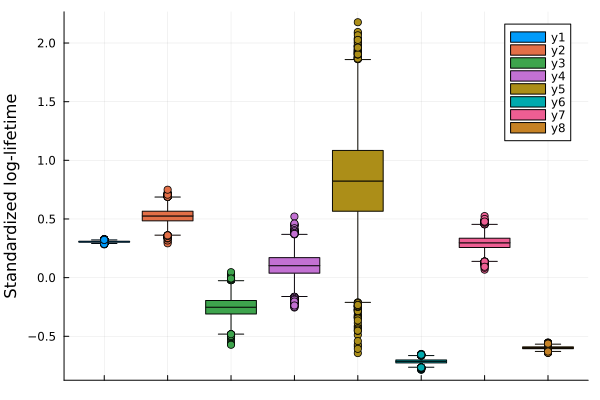

In [15]:
boxplot(prior_predictive_y, ylabel = "Standardized log-lifetime", xticks = (1:8, repeat([""], 8)))

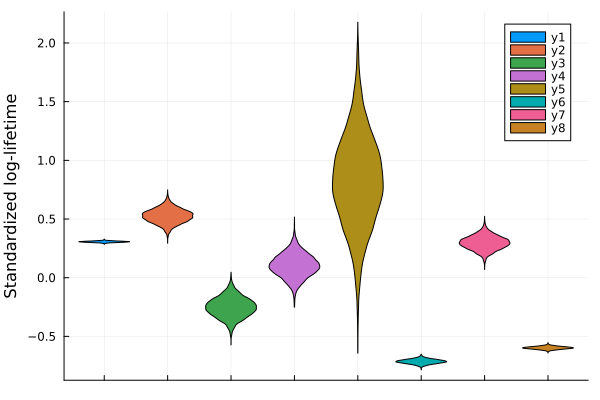

In [16]:
violin(prior_predictive_y, ylabel = "Standardized log-lifetime", xticks = (1:8, repeat([""], 8)))

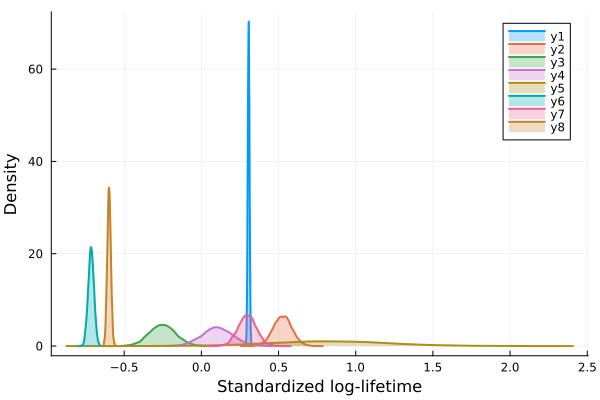

In [17]:
density(prior_predictive_y, ylabel = "Density", xlabel = "Standardized log-lifetime", linewidth = 2, fill = (0, 0.3))

This all looks fine, but it's not yet on the scale we're really interested in - the observation scale. We get to that scale by applying the inverse transformations in reverse order: first, we undo the standardization to get log-lifetimes, then we undo the log-scaling by exponentiating.

In [18]:
# Stack for easier handling
prior_predictive_y_stacked = vec(prior_predictive_y) 

64000-element Vector{Float64}:
  0.30234499210976357
  0.3031287393626182
  0.3021704756345662
  0.29667107934175163
  0.31526282495549834
  0.3110757559815259
  0.303465948854946
  0.3038726746713715
  0.30071434475773423
  0.3103740747419561
  ⋮
 -0.579728936118187
 -0.6142817420817522
 -0.5888894476744961
 -0.5970997567761401
 -0.6073651766604644
 -0.5735942495132913
 -0.6056238973575659
 -0.5952683599267812
 -0.5869676766594675

In [19]:
# Map to observation space
prior_predictive_lifetime_stacked = exp.(StatsBase.reconstruct(zed, prior_predictive_y_stacked))

64000-element Vector{Float64}:
 47.21304542127901
 47.22090477254663
 47.21129556287554
 47.15618690317219
 47.34275141920776
 47.30067071160056
 47.2242866833954
 47.22836610331011
 47.19669761912178
 47.29362236401776
  ⋮
 39.147472371799005
 38.86124771904129
 39.0713848272883
 39.00331537825323
 38.91837436838803
 39.19851012688316
 38.93276951006306
 39.01848871016053
 39.08733486013867

In [20]:
# Unstack
prior_predictive_lifetime = reshape(prior_predictive_lifetime_stacked, 8_000, 8)

8000×8 Matrix{Float64}:
 47.213   48.4582  41.7081  47.438   45.857   38.0925  47.4702  38.7784
 47.2209  49.7735  42.4525  46.4633  54.8797  38.0427  46.8381  38.773
 47.2113  49.4753  41.1205  44.3473  54.825   38.0412  47.2762  38.9924
 47.1562  49.8542  42.0295  44.5658  53.1946  37.9474  47.9452  38.9745
 47.3428  50.0648  42.312   44.3013  45.4293  38.2646  47.1056  39.1611
 47.3007  49.1824  41.552   44.4275  56.0966  37.8156  47.2548  39.1008
 47.2243  49.2948  41.0264  45.4959  62.0654  37.8004  47.6652  38.9707
 47.2284  50.1427  43.085   46.1471  62.7204  37.9235  46.9614  38.9824
 47.1967  48.3005  40.9265  44.7868  51.5661  37.9315  47.8341  38.982
 47.2936  50.4271  41.4365  46.6005  57.8689  38.1558  46.9384  38.9394
  ⋮                                            ⋮                
 47.3069  48.4836  42.9352  44.9246  49.0496  38.1607  48.2286  39.1475
 47.2348  49.1076  44.2102  45.6757  46.4102  37.9766  47.7158  38.8612
 47.1959  48.5914  42.1715  46.639   53.9398  38.

Now that we're on the observation scale, we can repeat our sanity checks here.

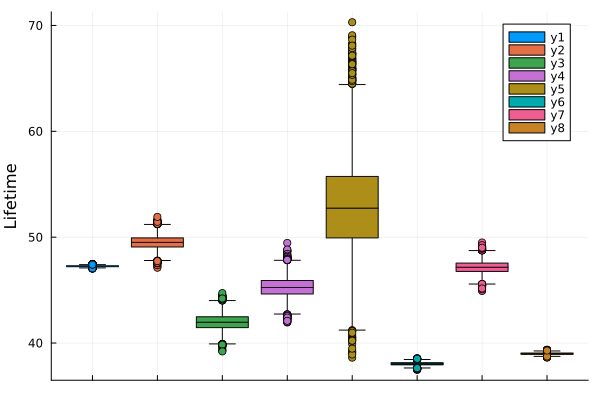

In [21]:
boxplot(prior_predictive_lifetime, ylabel = "Lifetime", xticks = (1:8, repeat([""], 8)))


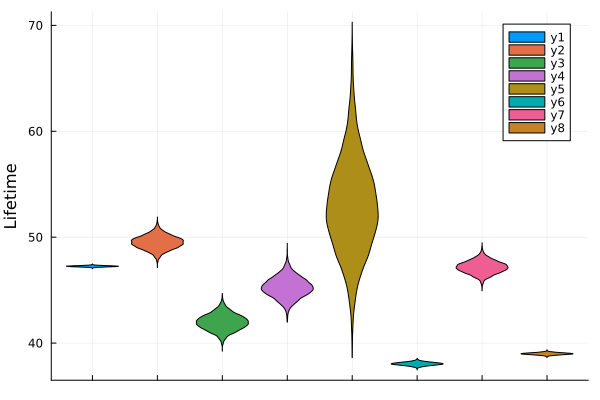

In [22]:
violin(prior_predictive_lifetime, ylabel = "Lifetime", xticks = (1:8, repeat([""], 8)))


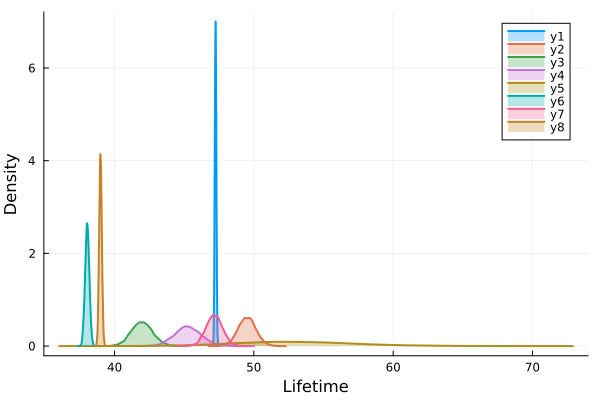

In [23]:
density(prior_predictive_lifetime, ylabel = "Density", xlabel = "Lifetime", linewidth = 2, fill = (0, 0.3))

We can see that there is a fair amount of variation of lifetimes both between and within simulated manufacturers while almost none of the simulated lifetimes is entirely outside the plausible range. So we are happy with our choice of priors. What is plausible depends entirely on our background knowledge of how the world works. The data alone cannot tell us this, and as opposed to our choice of model structure, we cannot justify our choice of hyperparameters (i.e., priors, which is what we're checking here) from first principles. All we can do is argue that our prior predictive distribution makes sense. It is the best summary of our modelling assumptions. As an exercise, you can ask yourself what the implied prior predictive distribution of a *t*-test is and whether that distribution makes sense.

(Answer: a *t*-test on lifetimes implies a prior predictive distribution that assigns the same probability to a lifetime of 50, which is plausible, as to one of 50 million, which is absurd, or of -50 million, which is impossible. In other words, almost all of the *t*-test's implied prior probability mass is outside the plausible range and much of it even in an impossible region. That doesn't make sense.)

As a second exercise, you can play around with the priors by choosing different hyperparameters and see how far you can go until the prior predictive distribution becomes unreasonable.

## Inference

### Posterior distribution

Our data design consists of the model applied to the data we're analyzing: the vector of standardized log-lifetimes and the vector of manufacturer indices.

In [24]:
data_design = gaussians(zlogt, m, 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Float64}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [1.3993688561978146, -0.7947457447553727, 0.340778656400273, -0.4081859381898525, 0.4386731037675281, -0.9353100132422784, -1.6031250496026244, -1.6180966148751486, 0.14897826417477072, 0.46764890789431085, 0.4483515312475099, 1.36766130667277, 0.7480027343102971], c = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())

Using this design with our chosen model, we sample from the posterior distribution. This gives us estimates of the mean and precision of the standardized log-lifetimes for manufacturers A and B.

In [25]:
posterior_sample = sample(data_design, NUTS(), 8_000, n_chains = 4)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/xm/.julia/packages/Turing/m3TxO/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:09:07
Sampling   1%|▍                                         |  ETA: 0:04:32
Sampling   2%|▋                                         |  ETA: 0:03:01
Sampling   2%|▉                                         |  ETA: 0:02:15
Sampling   2%|█                                         |  ETA: 0:01:48
Sampling   3%|█▎                                        |  ETA: 0:01:29
Sampling   4%|█▌                                        |  ETA: 0:01:16
Sampling   4%|█▋                                        |  ETA: 0:01:06
Sampling   4%|█▉                                        |  ETA: 0:00:59
Sampling   5%|██▏                                       |  ETA: 0:00:53
Sampling   6%|██▎                                       |  ETA: 0:00:48
Sampling   6%|██

Chains MCMC chain (8000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:9000
Number of chains  = 1
Samples per chain = 8000
Wall duration     = 3.31 seconds
Compute duration  = 3.31 seconds
parameters        = α[1], α[2], σ[1], σ[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        α[1]   -0.2470    0.2509    0.0032   6163.9433   5283.9662    0.9999   ⋯
        α[2]    0.6309    0.2177    0.0035   4374.3976   3546.6947    1.0000   ⋯
        σ[1]    0.8816    0.1742    0.0021   7341.5886   6020.1597    0.9999   ⋯
        σ[2]    0.4339    0.1554    0.0024   4594.7120   4973.0970    1.0004   ⋯
                                                   

The diagnostics of these samples ("chains" in the jargon) look good. The `rhat` values are close to 1 and the effect sample sizes (`ess_bulk` and `ess_tail`) are reasonably large (chains without any autocorrelation would have a value of 8,000). (Note that for the prior predictive sample, the same diagnostics are not interpretable because they are calculated across instead of within categories - a limitation of how prior predictive simulation is implemented here).

In addition to the numeric diagnostic values above, we plot our chains to get a visual impression: 

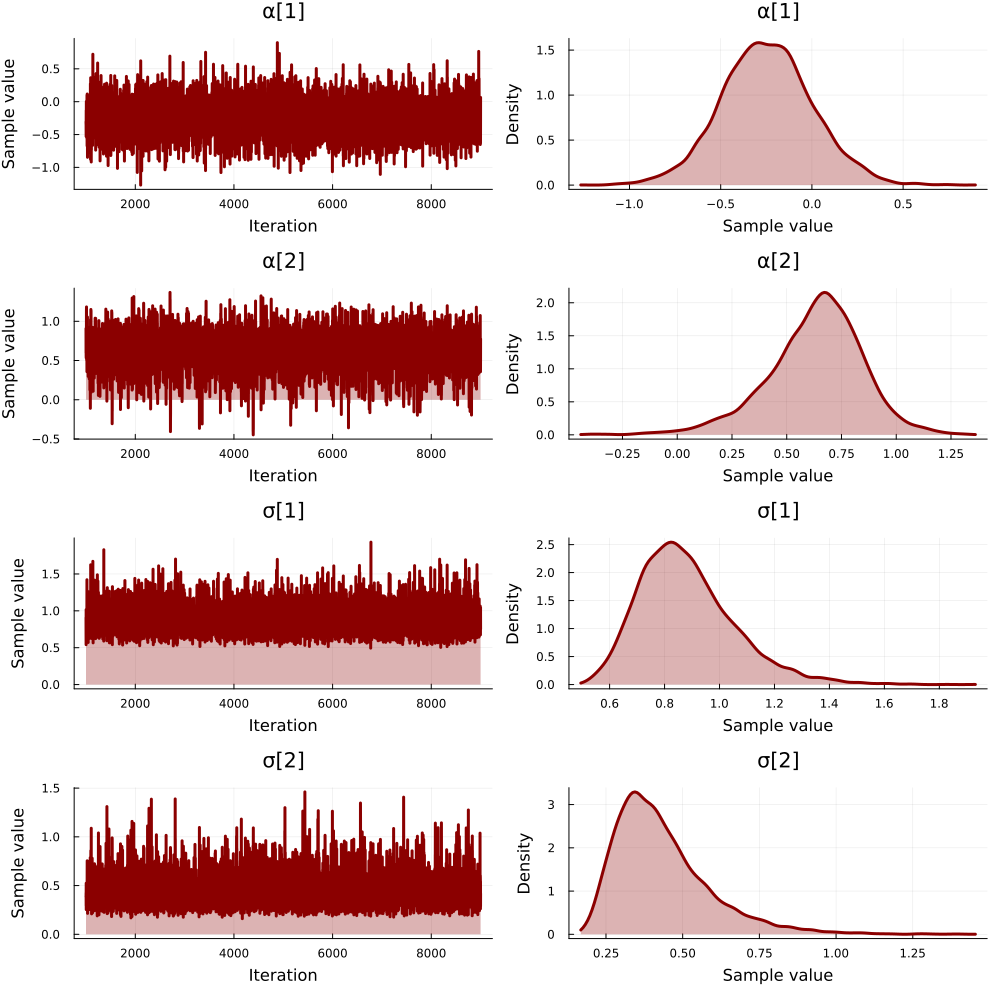

In [26]:
plot(posterior_sample, linewidth = 3, color = :darkred, fill = (0, 0.3, :darkred))

All chains look healthy.

### Comparison of posterior means

When the boss said it would be worth buying from manufacturer B if their parts lived at least three days longer, what did he mean, exactly? Would the *median lifetime* of parts from B have to be three days longer, or would the *predicted lifetime difference* of randomly chosen part from each manufacturer have to be at least three days? He wasn't clear about that, but these are two very different things. The first is a question about the posterior distribution, namely about the difference of the distribtuions of $\alpha[1]$ and $\alpha[2]$. The second is a question about the posterior predictive distribution, which we don't yet have. So let's just answer the first question for now.

We take the samples of $\alpha[1]$ and $\alpha[2]$ and transform them back to the observations scale, where we determine the proportion of times that the sample from $\alpha[2]$ was greater than that from $\alpha[1]$. Then we determine the proportion of times where the difference was greater than three. This gives us the probability that the median lifetime of parts from B is at least three days longer than that of those from A. If this probability is what the boss was after, how high would it need to be? He should have been specific also about that.


In [27]:
# Transform to observation scale
mean_a = exp.(StatsBase.reconstruct(zed, posterior_sample["α[1]"]))
mean_b = exp.(StatsBase.reconstruct(zed, posterior_sample["α[2]"]))

8000×1 Matrix{Float64}:
 53.69734395965092
 50.27120385316629
 52.535647885064456
 49.85545836999864
 49.58838731428753
 52.653060948509605
 50.83168703913405
 53.44120390725874
 52.111615612622224
 56.43886975258051
  ⋮
 52.19247341133106
 55.61281015363423
 49.32575061229796
 49.19344960703083
 47.780331021280595
 52.14690659487354
 47.76690249307695
 49.268002208907994
 52.211112257211624

In [28]:
# Probability that *median* lifetime from B is greater
sum(mean_b - mean_a .> 0) / length(posterior_sample)


0.9925

In [29]:
# Probability that *median* lifetime from B is more than 3 hours greater
sum(mean_b - mean_a .> 3) / length(posterior_sample)

0.9515

We see that this probability is around 95% *even though the t-test, which tests differences in the means of samples, said that the difference was non-significant!*. This is how far astray we can be led by dichotomizing into significant and non-significant. When the variances of the samples were not significantly different, we proceeded by pretending they were the same because those were the only alternatives we had: same or different - and according to how classical statistics is often practiced, what is not significant is taken not to exist. Then, after deciding that there was no difference in variance between the two samples, the equal-variance *t*-test also found no significant difference in means, which is again too often taken to mean that such a difference doesn't exist *even though probability theory (i.e., Bayesian inference) tells us that, under plausible assumptions, it is about 95%!*

In any case, the question the *t*-test addresses is not even the most relevant. More relevant than whether the means of the posterior distributions differ is the question how much longer we can expect a random part from B to live than a random part from A. More precisely, we can ask: what is the probability that a part from B lives at least three days longer than a part from A. This can be answered by looking at the posterior predictive distribution.

# Posterior predictive simulation

We simulate standardized log-lifetimes from the posterior predictive distribution by using a design where the observations are missing and only manufacturers 1 and 2 (i.e., A and B) are represented.

In [30]:
posterior_predictive_design = gaussians([missing, missing], [1, 2], 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Missing}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [missing, missing], c = [1, 2], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())

The `predict` function allows us to sample from the posterior predictive distribution by combining the posterior predictive design with the posterior distribution.

In [31]:
posterior_predictive_sample = predict(posterior_predictive_design, posterior_sample)

Chains MCMC chain (8000×2×1 Array{Float64, 3}):

Iterations        = 1:1:8000
Number of chains  = 1
Samples per chain = 8000
parameters        = y[1], y[2]
internals         = 

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        y[1]   -0.2351    0.9432    0.0107   7707.8979   7505.3601    1.0011   ⋯
        y[2]    0.6303    0.5030    0.0058   7878.3134   6815.7654    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        y[1]   -2.0749   -0.8400   -0.2519    0.3607    1.6442
        y[2]   -0.4326    0.3516    0.6521    0.9338    1.5980


Next, we transform to the observation scale and apply visual checks:

In [32]:
# Stack
posterior_predictive_sample_stacked = vec(posterior_predictive_sample.value)

16000-element reshape(::AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, 16000) with eltype Float64:
  0.4198208760611793
 -1.1891962962735754
 -0.45321377712055777
 -0.6633992553114858
 -0.8035398814532309
 -1.0923702947413794
 -0.36721179631734935
  0.22856333943352086
 -0.9981911339949971
 -0.2661623244399738
  ⋮
  2.199231506860717
  1.6033918906369369
  1.364874352420309
  0.2533118982517466
  1.0239793323600563
  0.9340590058459373
  0.4948617319434737
  0.4630573614556395
  0.736750030169617

In [33]:
# Map to observation space
posterior_predictive_lifetime_stacked = exp.(StatsBase.reconstruct(zed, posterior_predictive_sample_stacked))

16000-element Vector{Float64}:
 48.405803085924354
 34.39452896780586
 40.213593232583534
 38.45797169203915
 37.33021343521679
 35.109135379103314
 40.954845586890684
 46.47899699573654
 35.81844853675534
 41.84326971273938
  ⋮
 70.63529651909658
 62.239252854770044
 59.16497037135536
 46.72393772904596
 55.03286490354152
 53.99186139350223
 49.18343310581438
 48.85233840035098
 51.7761152291614

In [34]:
# Unstack
posterior_predictive_lifetime = reshape(posterior_predictive_lifetime_stacked, (8_000, 2))

8000×2 Matrix{Float64}:
 48.4058  58.8843
 34.3945  50.5445
 40.2136  45.1151
 38.458   50.5565
 37.3302  55.052
 35.1091  48.1296
 40.9548  51.1769
 46.479   47.8746
 35.8184  51.2
 41.8433  60.8796
  ⋮       
 44.9474  70.6353
 39.8218  62.2393
 32.1346  59.165
 47.539   46.7239
 44.8801  55.0329
 41.5881  53.9919
 45.0598  49.1834
 37.6135  48.8523
 53.7625  51.7761

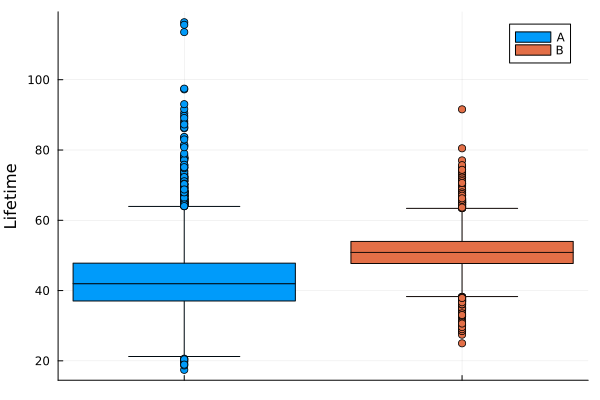

In [35]:
boxplot(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Lifetime", xticks = ([1, 2], ["", ""]))

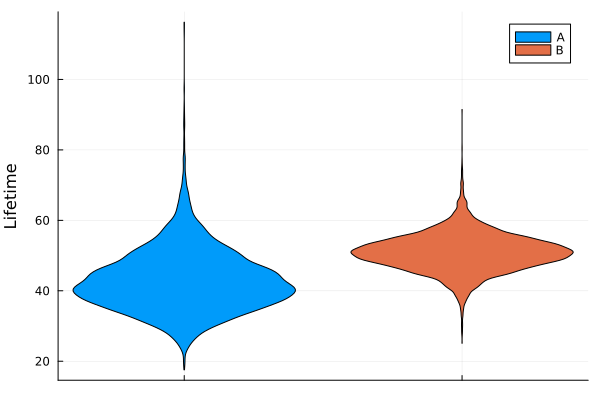

In [36]:
violin(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Lifetime", xticks = ([1, 2], ["", ""]))

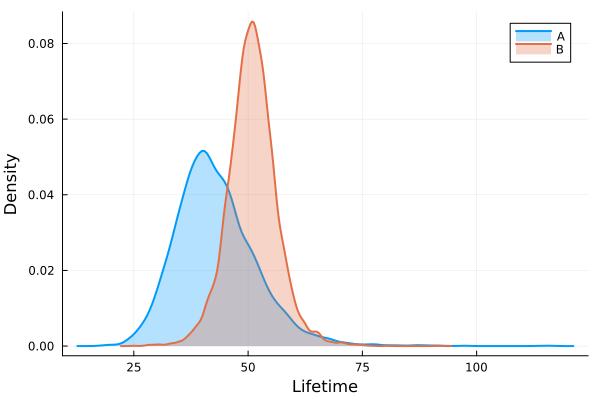

In [37]:
density(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Density", xlabel = "Lifetime", linewidth = 2, fill = (0, 0.3))

### Comparison of predicted lifetimes

Finally, we can compare predicted lifetimes.

In [38]:
t_a = posterior_predictive_lifetime[:, 1]
t_b = posterior_predictive_lifetime[:, 2]

8000-element Vector{Float64}:
 58.88430903308738
 50.54446798427216
 45.11507043382283
 50.556456632889095
 55.0519745761745
 48.129620515635615
 51.17686599950469
 47.87462102311022
 51.20004213751858
 60.87962314800655
  ⋮
 70.63529651909658
 62.239252854770044
 59.16497037135536
 46.72393772904596
 55.03286490354152
 53.99186139350223
 49.18343310581438
 48.85233840035098
 51.7761152291614

In [39]:
# Probability that when randomly choosing a part from each manufacturer,
# the lifetime of that from B is greater
sum(t_b - t_a .> 0) / length(posterior_predictive_sample)

0.800125

In [40]:
# Probability that when randomly choosing a part from each manufacturer,
# the lifetime of that from B is more than 3 hours greater
sum(t_b - t_a .> 3) / length(posterior_predictive_sample)

0.713125

In conclusion, if a probability of about 70% that parts from B will live at least three days longer than parts from A is good enough for the boss, then he should buy from B.